# Final project
### Structural Bioinformatics | Skoltech | 2025
### Contributors
Veronika Karpushenkova<br>


# Import the necessary packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import MDAnalysis as mda
import nglview as nv
import prolif as plf
import Bio
from pymol import cmd
import py3Dmol
import sys, os
from prolif.plotting.network import LigNetwork
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from IPython.display import display, Image
from io import BytesIO
from openbabel import pybel
from pdbfixer import PDBFixer
import openmm
from simtk.openmm.app import PDBFile
from MDAnalysis import Universe
import matplotlib.pyplot as plt
from matplotlib import colors
import opencadd
from opencadd.structure.core import Structure
import pandas as pd
import numpy as np
import plip
from plip.structure.preparation import PDBComplex
from plip.exchange.report import BindingSiteReport
from Bio import PDB

/home/veronika/miniconda3/envs/binding_env/lib/python3.10/site-packages/MDAnalysis/topology/tables.py:52: DeprecationWarning: Deprecated in version 2.8.0
MDAnalysis.topology.tables has been moved to MDAnalysis.guesser.tables. This import point will be removed in MDAnalysis version 3.0.0
  warnings.warn(wmsg, category=DeprecationWarning)


In [3]:
color_map = {
    "hydrophobic": [0.90, 0.10, 0.29],
    "hbond": [0.26, 0.83, 0.96],
    "waterbridge": [1.00, 0.88, 0.10],
    "saltbridge": [0.67, 1.00, 0.76],
    "pistacking": [0.75, 0.94, 0.27],
    "pication": [0.27, 0.60, 0.56],
    "halogen": [0.94, 0.20, 0.90],
    "metal": [0.90, 0.75, 1.00],
}

# Functions

### Downloading structures for PDB database

With Biopython:

In [4]:
import os
import subprocess

def load_pdb_structure(pdb_id, file_format="pdb"):
    """
    Load a PDB structure by its ID from the PDB database.

    Parameters:
    - pdb_id: str, the four-letter PDB ID.
    - file_format: str, the format of the downloaded file (default is "pdb").

    Returns:
    - The path to the downloaded PDB file.
    """
    # Construct the URL for downloading the PDB file
    if file_format == "pdb":
        url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    elif file_format == "mmCif":
        url = f"https://files.rcsb.org/download/{pdb_id}.cif"
    else:
        raise ValueError("Unsupported file format. Only 'pdb' and 'mmCif' are supported.")
    
    # Construct the filename based on the PDB ID and file format
    if file_format == "pdb":
        filename = f"{pdb_id}.pdb"
    elif file_format == "mmCif":
        filename = f"{pdb_id}.cif"
    
    # Download the file using wget
    subprocess.run(['wget', url, '-O', filename])
    
    # Return the path to the downloaded file
    return os.path.abspath(filename)

or with Pymol:

In [5]:
from pymol import cmd
def loading_structure(pdb_id, file_format='pdb'):
    """ 
    Loads a protein structure from the Protein Data Bank (PDB) and separates the protein from ligands.
    
    Parameters:
    - pdb_id (str): The four-letter PDB ID of the structure to fetch.
    - file_format (str): The format of the downloaded file (default is "pdb").
    
    Returns:
    - Saves the protein structure in .pdb format and ligand(s) in .mol2 format.
    """
    try:
        # Fetch the structure from PDB
        cmd.fetch(code=pdb_id, type=file_format)
        
        # Select protein chains
        cmd.select(name='Prot', selection='polymer.protein')
        
        # Select organic ligands
        cmd.select(name='Lig', selection='organic')
        
        # Save protein structure to a PDB file
        cmd.save(filename=f'{pdb_id}_clean.pdb', format='pdb', selection='Prot')
        
        # Save ligand structure to a MOL2 file
        cmd.save(filename=f'{pdb_id}_lig.mol2', format='mol2', selection='Lig')
        
        # Clear workspace to free memory
        cmd.delete('all')
        
        print(f"Structures saved: {pdb_id}_clean.pdb (protein), {pdb_id}_lig.mol2 (ligand)")
    
    except Exception as e:
        print(f"An error occurred: {e}")

### Uploading structure from current directory

With Biopython

In [6]:
def upload_structure(pdb_id):
    parser = PDBParser()
    structure = parser.get_structure("Structure", f"{pdb_id}.pdb")
    return structure

With Pymol

In [7]:
from pymol import cmd

def loading_structure_from_dir(structure_filename):
    """ 
    Loads a protein structure from a manually downloaded file and separates the protein from ligands.
    
    Parameters:
    - pdb_id (str): The four-letter PDB ID of the structure (used for naming output files).
    - file_format (str): The format of the local file (default is "pdb").
    
    Returns:
    - Saves the protein structure in .pdb format and ligand(s) in .mol2 format.
    """
    try:
        # Load the structure from local file (assuming filename is pdb_id.format)
        cmd.load(filename=structure_filename)
        
        # Select protein chains
        cmd.select(name='Prot', selection='polymer.protein')
        
        # Select organic ligands
        cmd.select(name='Lig', selection='organic')
        
        # Save protein structure to a PDB file
        cmd.save(filename=f'{pdb_id}_clean.pdb', format='pdb', selection='Prot')
        
        # Save ligand structure to a MOL2 file
        cmd.save(filename=f'{pdb_id}_lig.mol2', format='mol2', selection='Lig')
        
        # Clear workspace to free memory
        cmd.delete('all')
        
        print(f"Structures saved: {pdb_id}_clean.pdb (protein), {pdb_id}_lig.mol2 (ligand)")
    
    except Exception as e:
        print(f"An error occurred: {e}")

### Visualizing

With MDanalysis:

In [8]:
def parse_het_records(pdb_id):
        """Parse HET records from PDB file to identify ligands."""
        ligands = set()
        with open(f"{pdb_id}.pdb", 'r') as f:
            for line in f:
                if line.startswith('HET '):  # Note the space after HET
                    resname = line[7:10].strip()
                    ligands.add(resname)
                elif line.startswith('HETNAM'):
                    # Optional: Could store the full ligand names
                    pass
        ligand_resname = sorted(list(ligands))
        return ligand_resname

In [9]:
def mda_visual(pdb_id, ligand_resname):
    """
    Visualizes a protein structure with specified ligands using MDAnalysis and NGLView.

    Parameters:
    - **pdb_id**: The ID of the PDB file to load (e.g., "1abc").
    - **ligand_resname**: A list of ligand residue names to highlight in the visualization.

    Returns:
    - **view**: An NGLView object displaying the protein with highlighted ligands.

    Notes:
    - The function loads a PDB file based on the provided `pdb_id`.
    - It selects the protein and specified ligands from the PDB file.
    - The protein is visualized as a surface colored by hydrophobicity.
    - Ligands are added to the visualization if they are found in the PDB file.
    - If no ligands are found, a message is printed, and the protein is displayed alone.
    """
    u = mda.Universe(f"{pdb_id}.pdb")
    
    # Select protein and ligands
    protein = u.select_atoms("protein")
    ligands = [(name, u.select_atoms(f"resname {name}")) for name in ligand_resname]
    
    # Create visualization base
    view = nv.show_mdanalysis(protein)
    view.clear_representations()
    view.add_representation("surface", colorScheme="hydrophobicity")
    
    # Track ligand findings
    any_ligand_found = False
    
    for lig_name, lig in ligands:
        if lig.n_atoms > 0:
            # Add ligand to visualization
            lig_view = view.add_component(lig)
            lig_view.center()
            any_ligand_found = True
        else:
            print(f"Warning: No ligand {lig_name} found in {pdb_id}")
    
    if not any_ligand_found:
        print(f"No valid ligands found in {pdb_id}. Showing protein only.")
        
    return view

With Pymol3D:

In [10]:
def pymol3d_visual(pdb_id):
    """
    Visualizes a protein structure with its ligand using Py3Dmol.

    Parameters:
    - **pdb_id**: The ID of the PDB file to load (e.g., "1abc"). The function expects two files:
      - `{pdb_id}_clean.pdb`: A cleaned version of the protein structure.
      - `{pdb_id}_lig.mol2`: The ligand structure in MOL2 format.

    Returns:
    - **view**: A Py3Dmol view object displaying the protein with its ligand.

    Notes:
    - The protein is visualized as an oval cartoon with arrows and tubes.
    - A surface representation is added to the protein with 60% opacity.
    - The ligand is displayed as sticks with a green carbon color scheme.
    - The view is zoomed to fit the entire structure.
    """
    view = py3Dmol.view()
    view.removeAllModels()
    view.setViewStyle({'style':'outline','color':'black','width':0.1})
    
    view.addModel(open(f'{pdb_id}_clean.pdb','r').read(),format='pdb')
    Prot=view.getModel()
    Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
    view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})
    
    
    view.addModel(open(f'{pdb_id}_lig.mol2','r').read(),format='mol2')
    ref_m = view.getModel()
    ref_m.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.2}})
    
    view.zoomTo()
    view.show()
    return view

### Checking ligand structure if any:

In [11]:
def visualize_multiple_ligands_from_mol2(pdb_id):
    """
    Extract and visualize multiple ligands, handling identical ligands, from a .mol2 file.
    Allows specifying image size.
    """
    view = py3Dmol.view()
    view.removeAllModels()
    view.setViewStyle({'style':'outline','color':'black','width':0.1})
    
    # view.addModel(open(f'{pdb_id}_clean.pdb','r').read(),format='pdb')
    # Prot=view.getModel()
   # Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
    # view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})
    
    
    view.addModel(open(f'{pdb_id}_lig.mol2','r').read(),format='mol2')
    ref_m = view.getModel()
    ref_m.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.2}})
    
    view.zoomTo()
    #view.show()
    return view

### Visualizing binding site:

In [12]:
def visualize_binding_site(pdb_id, ligand_resname):
    """
    Visualizes the binding site of a protein with specified ligands using MDAnalysis and NGLView.
    Additionally, it analyzes interactions between the protein and ligands using ProLIF.

    Parameters:
    - **pdb_id**: The ID of the PDB file to load (e.g., "1abc").
    - **ligand_resname**: A list of ligand residue names to highlight in the visualization.

    Returns:
    - **view**: An NGLView object displaying the protein with highlighted ligands and their binding site.

    Notes:
    - The protein is visualized as a cartoon with both electrostatic and secondary structure color schemes.
    - The camera view is set to orthographic for better visualization.
    - Ligands are added to the visualization if they are found in the PDB file.
    - For each found ligand, interactions with the protein are analyzed using ProLIF and printed to the console.
    - If no ligands are found, a message is printed, and the protein is displayed alone.
    """
    u = mda.Universe(f"{pdb_id}.pdb")
    
    # Select protein and ligands
    protein = u.select_atoms("protein")
    ligands = [(name, u.select_atoms(f"resname {name}")) for name in ligand_resname]
    
    # Create visualization base
    view = nv.show_mdanalysis(u)
    view.clear_representations()
    view.add_representation("cartoon", colorScheme="electrostatic", opacity=0.5)  # Shows charge
    view.add_representation("cartoon", colorScheme="sstruc", opacity=0.5)  # Secondary structure
    #view.add_representation("surface", color="lightgray", opacity=0.5)  # Uniform color
    
    view.camera = "orthographic"
    
    # Track ligand findings
    any_ligand_found = False
    
    for lig_name, lig in ligands:
        if lig.n_atoms > 0:
            # Add ligand to visualization
            lig_view = view.add_component(lig)
            lig_view.center()
            any_ligand_found = True
            # Use ProLIF to analyze interactions with NoImplicit=False
            try:
                protein_mol = plf.Molecule.from_mda(protein, NoImplicit=False)
                ligand_mol = plf.Molecule.from_mda(lig, NoImplicit=False)
                fp = plf.Fingerprint()
                interactions = fp.generate(protein_mol, ligand_mol)
            
                # Display interactions
                print("Interactions:")
                for interaction in interactions:
                    print(interaction)
            except Exception as e:
                print(f"Could not analyze interactions: {e}")
        else:
            print(f"Warning: No ligand {lig_name} found in {pdb_id}")
    
    if not any_ligand_found:
        print(f"No valid ligands found in {pdb_id}. Showing protein only.")
    
    return view

### Visualizing in interaction:

In [13]:
def visualize_protein_ligand_interactions(pdb_path, ligand_name):
    """
    Visualizes the interactions between a protein and a specified ligand in a PDB file.
    It identifies interacting residues and hydrogen bonds, then displays these interactions using NGLView.

    Parameters:
    - **pdb_path**: The path to the PDB file containing the protein-ligand complex.
    - **ligand_name**: The residue name of the ligand to analyze.

    Returns:
    - **view**: An NGLView object showing the protein-ligand complex with highlighted interacting residues and hydrogen bonds.

    Notes:
    - The function uses a simple distance-based approach to detect hydrogen bonds, which might need refinement with angle criteria for more accurate results.
    - Interacting residues are defined as those within 5 Å of the ligand.
    - Hydrogen bonds are represented as dashed lines between donor and acceptor atoms.
    """
    parser = PDB.PDBParser()
    structure = parser.get_structure('protein', pdb_path)
    
    # Find interacting residues and hydrogen bonds
    ligand_atoms = []
    for atom in structure.get_atoms():
        if atom.get_parent().get_resname() == ligand_name:
            ligand_atoms.append(atom)
    
    interacting_residues = []
    hydrogen_bonds = []  # Will store tuples of (ligand_atom, protein_atom)
    
    for model in structure:
        for chain in model:
            for residue in chain:
                if residue.get_resname() != ligand_name:
                    for atom1 in ligand_atoms:
                        for atom2 in residue:
                            distance = np.linalg.norm(np.array(atom1.get_coord()) - np.array(atom2.get_coord()))
                            if distance <= 5:
                                interacting_residues.append(residue)
                                
                                # Simple hydrogen bond detection (distance-based)
                                # You might want to refine this with angle criteria
                                if distance <= 3.5:  # Typical H-bond distance cutoff
                                    # Check if one atom is donor (N,O) and other is acceptor (O,N)
                                    donor_types = ['N', 'O']
                                    acceptor_types = ['O', 'N']
                                    if (atom1.element in donor_types and atom2.element in acceptor_types) or \
                                       (atom1.element in acceptor_types and atom2.element in donor_types):
                                        hydrogen_bonds.append((atom1, atom2))
                                break
                        else:
                            continue
                        break
    
    # Visualize the structure using nglview
    view = nv.show_file(pdb_path)
    
    # Highlight the ligand and interacting residues
    view.add_representation('ball+stick', selection=f'resn {ligand_name}', color='red')
    for residue in interacting_residues:
        view.add_representation('ball+stick', selection=f'resi {residue.get_id()[1]}', color='blue')
    
    # Add dashed lines for hydrogen bonds
    for atom1, atom2 in hydrogen_bonds:
        # Get atom identifiers
        atom1_id = f"{atom1.get_parent().get_id()[1]}:{atom1.get_parent().get_resname()}:{atom1.get_name()}"
        atom2_id = f"{atom2.get_parent().get_id()[1]}:{atom2.get_parent().get_resname()}:{atom2.get_name()}"
        
        # Add dashed line representation
        view.add_distance(
            atom_pair=[f"{atom1_id}", f"{atom2_id}"],
            color='white',
            dashed=True,
            dashLength=0.2,
            labelVisible=False
        )
    
    # Display the view
    return view

### Visualizing with PLIP and opencadd:

In [14]:
def retrieve_plip_interactions(pdb_id):
    """
    Retrieves the interactions from PLIP.

    Parameters
    ----------
    pdb_file :
        The PDB file of the complex.

    Returns
    -------
    dict :
        A dictionary of the binding sites and the interactions.
    """
    protlig = PDBComplex()
    protlig.load_pdb(f"{pdb_id}.pdb")  # load the pdb file
    for ligand in protlig.ligands:
        protlig.characterize_complex(ligand)  # find ligands and analyze interactions
    sites = {}
    # loop over binding sites
    for key, site in sorted(protlig.interaction_sets.items()):
        binding_site = BindingSiteReport(site)  # collect data about interactions
        # tuples of *_features and *_info will be converted to pandas DataFrame
        keys = (
            "hydrophobic",
            "hbond",
            "waterbridge",
            "saltbridge",
            "pistacking",
            "pication",
            "halogen",
            "metal",
        )
        # interactions is a dictionary which contains relevant information for each
        # of the possible interactions: hydrophobic, hbond, etc. in the considered
        # binding site. Each interaction contains a list with
        # 1. the features of that interaction, e.g. for hydrophobic:
        # ('RESNR', 'RESTYPE', ..., 'LIGCOO', 'PROTCOO')
        # 2. information for each of these features, e.g. for hydrophobic
        # (residue nb, residue type,..., ligand atom 3D coord., protein atom 3D coord.)
        interactions = {
            k: [getattr(binding_site, k + "_features")] + getattr(binding_site, k + "_info")
            for k in keys
        }
        sites[key] = interactions
    return sites

In [15]:
def create_df_from_binding_site(selected_site_interactions, interaction_type="hbond"):
    """
    Creates a data frame from a binding site and interaction type.

    Parameters
    ----------
    selected_site_interactions : dict
        Precaluclated interactions from PLIP for the selected site
    interaction_type : str
        The interaction type of interest (default set to hydrogen bond).

    Returns
    -------
    pd.DataFrame :
        DataFrame with information retrieved from PLIP.
    """

    # check if interaction type is valid:
    valid_types = [
        "hydrophobic",
        "hbond",
        "waterbridge",
        "saltbridge",
        "pistacking",
        "pication",
        "halogen",
        "metal",
    ]

    if interaction_type not in valid_types:
        print("!!! Wrong interaction type specified. Hbond is chosen by default!!!\n")
        interaction_type = "hbond"

    df = pd.DataFrame.from_records(
        # data is stored AFTER the column names
        selected_site_interactions[interaction_type][1:],
        # column names are always the first element
        columns=selected_site_interactions[interaction_type][0],
    )
    return df

In [16]:
def show_interactions_3d(
    pdb_id, selected_site_interactions, highlight_interaction_colors=color_map,
    interaction_data=None, dash_length=0.3, dash_gap=0.2, show_dash_lengths=False
):
    """
    3D visualization of protein-ligand interactions with permanent labels and dashed bonds.

    Parameters
    ----------
    pdb_id : str
        The pdb ID of interest.
    selected_site_interactions : dict
        Precalculated interactions from PLIP for the selected site
    highlight_interaction_colors : dict
        The colors used to highlight the different interaction types.
    interaction_data : DataFrame
        DataFrame containing detailed interaction information (from create_df_from_binding_site)
    dash_length : float
        Length of each dash in the dashed line (in nanometers)
    dash_gap : float
        Length of gap between dashes (in nanometers)
    show_dash_lengths : bool
        Whether to show individual dash lengths (False shows only total bond length)

    Returns
    -------
    NGL viewer with explicit interactions given by PLIP and additional annotations.
    """

    # Create NGLviewer
    viewer = nv.NGLWidget(height="600px", default=True, gui=True)
    # Add protein
    prot_component = viewer.add_pdbid(pdb_id)
    # Add the ligands
    viewer.add_representation(repr_type="ball+stick", selection="hetero and not water")

    interacting_residues = []
    
    for interaction_type, interaction_list in selected_site_interactions.items():
        color = highlight_interaction_colors[interaction_type]
        if len(interaction_list) == 1:
            continue
            
        df_interactions = pd.DataFrame.from_records(
            interaction_list[1:], columns=interaction_list[0]
        )
        
        for _, interaction in df_interactions.iterrows():
            # Convert coordinates to numpy arrays if they aren't already
            lig_coo = np.array(eval(interaction["LIGCOO"]) if isinstance(interaction["LIGCOO"], str) else interaction["LIGCOO"])
            prot_coo = np.array(eval(interaction["PROTCOO"]) if isinstance(interaction["PROTCOO"], str) else interaction["PROTCOO"])
            
            # Calculate vector between points and total distance
            vec = prot_coo - lig_coo
            distance = np.linalg.norm(vec)
            unit_vec = vec / distance
            
            # Find corresponding interaction in interaction_data if provided
            dist = None
            res_info = ""
            if interaction_data is not None:
                # Find matching interaction
                match = interaction_data[
                    (interaction_data["RESNR"] == interaction["RESNR"]) & 
                    (interaction_data["RESTYPE"] == interaction["RESTYPE"]) &
                    (interaction_data["RESCHAIN"] == interaction["RESCHAIN"])
                ]
                if not match.empty:
                    dist = match.iloc[0]["DIST"]
                    # Ensure distance is a number
                    if isinstance(dist, str):
                        try:
                            dist = float(dist)
                        except ValueError:
                            dist = distance
                    res_info = f"{interaction['RESTYPE']}{interaction['RESNR']}"
            
            # If no interaction_data provided or distance couldn't be determined, use calculated distance
            if dist is None:
                dist = distance
                res_info = f"{interaction['RESTYPE']}{interaction['RESNR']}"
            
            # Format the label text - ensure dist is a float
            try:
                dist_float = float(dist)
                label_text = f"{res_info}\n{dist_float:.2f}Å"
            except (ValueError, TypeError):
                label_text = f"{res_info}\n{distance:.2f}Å"  # Fallback to calculated distance
            
            # Add permanent label using add_representation
            viewer.add_representation(
                repr_type="label",
                selection=f"({interaction['RESNR']} and not _H)",
                param={
                    "labelType": "text",
                    "labelText": [label_text],
                    "color": "black",
                    "backgroundColor": color,
                    "backgroundOpacity": 0.7,
                    "fontFamily": "sans-serif",
                    "size": 2.0,
                    "showBackground": True
                }
            )
            
            # Create dashed line
            num_dashes = int(distance / (dash_length + dash_gap))
            for i in range(num_dashes):
                start = lig_coo + unit_vec * (i * (dash_length + dash_gap))
                end = start + unit_vec * dash_length
                if i == num_dashes - 1:  # Last dash might need to be shorter
                    end = prot_coo
                
                # Add cylinder segment
                viewer.shape.add_cylinder(
                    list(start),
                    list(end),
                    color,
                    [0.1],
                    interaction_type
                )
                
                # Optionally add label for each dash segment's length
                if show_dash_lengths:
                    dash_midpoint = list(start + unit_vec * (dash_length / 2))
                    dash_label_text = f"{dash_length:.2f}Å"
                    viewer.add_representation(
                        repr_type="label",
                        selection=f"({interaction['RESNR']} and not _H)",
                        param={
                            "labelType": "text",
                            "labelText": [dash_label_text],
                            "color": "black",
                            "backgroundColor": color,
                            "backgroundOpacity": 0.7,
                            "position": dash_midpoint,
                            "fontFamily": "sans-serif",
                            "size": 1.5,
                            "showBackground": True
                        }
                    )
            
            # Add bond length label at midpoint of entire bond
            bond_midpoint = list(lig_coo + unit_vec * (distance / 2))
            viewer.add_representation(
                repr_type="label",
                selection=f"({interaction['RESNR']} and not _H)",
                param={
                    "labelType": "text",
                    "labelText": [f"Total: {distance:.2f}Å"],
                    "color": "black",
                    "backgroundColor": color,
                    "backgroundOpacity": 0.7,
                    "position": bond_midpoint,
                    "fontFamily": "sans-serif",
                    "size": 1.5,
                    "showBackground": True
                }
            )
            
            interacting_residues.append(interaction["RESNR"])
    
    # Display interacting residues
    res_sele = " or ".join([f"({r} and not _H)" for r in interacting_residues])
    res_sele_nc = " or ".join([f"({r} and ((_O) or (_N) or (_S)))" for r in interacting_residues])
    prot_component.add_ball_and_stick(sele=res_sele, colorScheme="chainindex", aspectRatio=1.5)
    prot_component.add_ball_and_stick(sele=res_sele_nc, colorScheme="element", aspectRatio=1.5)
    
    # Center on ligand
    viewer.center("ligand")
    
    # Ensure viewer is fully loaded before returning
    import time
    time.sleep(1)  # Wait for 1 second
    
    return viewer

# Examples

### Write your PDB ID and parse the structure

In [17]:
os.listdir()

['2baw_lig.mol2',
 '2vsk.pdb',
 '2vsk_lig.mol2',
 '9fbd.pdb',
 '9nbf.pdb',
 '3vsk_clean.pdb',
 '9fbd_lig_H.mol2',
 '9fbd_lig_0_H.mol2',
 '9fbd_clean_H.pdb',
 'temp.png',
 '9nbf_clean.pdb',
 'pdb3vsk.ent',
 'auto_binding_vis.ipynb',
 'pdb6vnt.ent_lig.mol2',
 '9fbd_lig_molecule_1_with_H.mol2',
 '9fbd_lig.mol2',
 'pdb1lag.ent_lig.mol2',
 '4hhb_lig.mol2',
 'pdb6vn4.ent_lig.mol2',
 '4hhb_clean.pdb',
 '3poz_lig.mol2',
 'obsolete',
 'pdb9nbf.ent_lig.mol2',
 '3vsk_lig.mol2',
 '3vsk.pdb',
 '2baw.pdb',
 '.ipynb_checkpoints',
 '7hbw_lig.mol2',
 '3poz.pdb',
 '3poz_clean.pdb',
 '9nbf_lig.mol2',
 '9fbd_clean_processed.pdb',
 'pdb6vnt.ent_clean.pdb',
 'pdb2baw.ent_lig.mol2',
 '2vsk_clean.pdb',
 '7hbw_clean.pdb',
 'pdb1lag.ent_clean.pdb',
 'pdb4hhb.ent',
 'pdb6vn4.ent_clean.pdb',
 '4hhb.pdb',
 '2baw_clean.pdb',
 'pdb2baw.ent_clean.pdb',
 '9fbd_clean.pdb',
 'pdb9fbd.ent',
 'pdb9nbf.ent_clean.pdb']

In [19]:
pdb_id = "3vsk"
pdb_filename = load_pdb_structure(pdb_id)

--2025-03-27 03:06:06--  https://files.rcsb.org/download/3vsk.pdb
Resolving files.rcsb.org (files.rcsb.org)... 108.157.229.82, 108.157.229.100, 108.157.229.74, ...
Connecting to files.rcsb.org (files.rcsb.org)|108.157.229.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘3vsk.pdb’

     0K .......... .......... .......... .......... ..........  457K
    50K .......... .......... .......... .......... ..........  273K
   100K .......... .......... .......... .......... ..........  293K
   150K .......... .......... .......... .......... ..........  377K
   200K .......... .......... .......... .......... ..........  294K
   250K .......... .......... .......... .......... ..........  128K
   300K .......... .......... .......... .......... ..........  875K
   350K .......... .......... .......... .......... ..........  217K
   400K .......... .......... .......... .......... ..........  307K
   450K ..........

or

In [20]:
pdb_id = "3vsk"
loading_structure(pdb_id)

Structures saved: 3vsk_clean.pdb (protein), 3vsk_lig.mol2 (ligand)


### Loading PDB to MDAnalysis

In [21]:
ligands = parse_het_records(pdb_id)
view = mda_visual(pdb_id, ligands)
view

No valid ligands found in 3vsk. Showing protein only.


NGLWidget()

In [22]:
view = pymol3d_visual(pdb_id)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### Complex

In [23]:
pdb_id = '9fbd'

In [24]:
pdb_filename = load_pdb_structure(pdb_id)

--2025-03-27 03:07:52--  https://files.rcsb.org/download/9fbd.pdb
Resolving files.rcsb.org (files.rcsb.org)... 108.157.229.82, 108.157.229.100, 108.157.229.30, ...
Connecting to files.rcsb.org (files.rcsb.org)|108.157.229.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘9fbd.pdb’

     0K .......... .......... .......... .......... ..........  243K
    50K .......... .......... .......... .......... ..........  223K
   100K .......... .......... .......... .......... ..........  591K
   150K .......... .......... .......... .......... ..........  797K
   200K .......... .......... .......... .......... ..........  790K
   250K .......... .......... .......... .......... ..........  764K
   300K .......... .......... .......... .......... .......... 1.02M
   350K .......... .......... .......... .......... ..........  922K
   400K .......... .......... .......... .......... .......... 1.10M
   450K ..........

In [25]:
loading_structure(pdb_id)

Structures saved: 9fbd_clean.pdb (protein), 9fbd_lig.mol2 (ligand)


In [26]:
ligands = parse_het_records(pdb_id)
view = mda_visual(pdb_id, ligands)
view

NGLWidget()

In [27]:
view = pymol3d_visual(pdb_id)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [28]:
visualize_multiple_ligands_from_mol2(pdb_id)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [29]:
ligand_resname = parse_het_records(pdb_id)
view = visualize_binding_site(pdb_id, ligand_resname)

Interactions:
(ResidueId(ASP, 34, A), ResidueId(NAD, 301, A))
(ResidueId(LYS, 98, A), ResidueId(NAD, 301, A))
(ResidueId(ASN, 118, A), ResidueId(NAD, 301, A))
(ResidueId(SER, 120, A), ResidueId(NAD, 301, A))
(ResidueId(ASP, 34, B), ResidueId(NAD, 301, B))
(ResidueId(LYS, 98, B), ResidueId(NAD, 301, B))
(ResidueId(ASN, 118, B), ResidueId(NAD, 301, B))
(ResidueId(SER, 120, B), ResidueId(NAD, 301, B))
(ResidueId(ASN, 144, B), ResidueId(NAD, 301, B))
(ResidueId(ASP, 34, C), ResidueId(NAD, 301, C))
(ResidueId(LYS, 98, C), ResidueId(NAD, 301, C))
(ResidueId(ASN, 118, C), ResidueId(NAD, 301, C))
(ResidueId(ASP, 34, D), ResidueId(NAD, 301, D))
(ResidueId(LYS, 98, D), ResidueId(NAD, 301, D))
(ResidueId(ASN, 118, D), ResidueId(NAD, 301, D))
(ResidueId(SER, 120, D), ResidueId(NAD, 301, D))
(ResidueId(ASP, 34, E), ResidueId(NAD, 301, E))
(ResidueId(LYS, 98, E), ResidueId(NAD, 301, E))
(ResidueId(ASN, 118, E), ResidueId(NAD, 301, E))
(ResidueId(SER, 120, E), ResidueId(NAD, 301, E))
(ResidueId(ASP, 

In [30]:
view

NGLWidget()

### Protein with one ligand

In [31]:
# Example usage
pdb_id = "3poz"
pdb_filename = load_pdb_structure(pdb_id)
print(pdb_filename)

--2025-03-27 03:11:21--  https://files.rcsb.org/download/3poz.pdb
Resolving files.rcsb.org (files.rcsb.org)... 108.157.229.30, 108.157.229.100, 108.157.229.74, ...
Connecting to files.rcsb.org (files.rcsb.org)|108.157.229.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘3poz.pdb’

     0K .......... .......... .......... .......... ..........  167K
    50K .......... .......... .......... .......... ..........  553K
   100K .......... .......... .......... .......... ..........  481K
   150K .......... .......... .......... .......... ..........  310K
   200K .......... .......... .......... .......... ..........  358K
   250K .......... .......... .......... .......... ..........  369K
   300K .......... .......... .......... .......... ..........  382K
   350K .......... .......... ...

/home/veronika/auto_bind_vis/auto-binding-visualizer/examples/3poz.pdb


....... .......... ..........  253K
   400K .......... .......... .......... .                      314K=1.4s

2025-03-27 03:11:25 (318 KB/s) - ‘3poz.pdb’ saved [442179]



In [32]:
loading_structure(pdb_id)

Structures saved: 3poz_clean.pdb (protein), 3poz_lig.mol2 (ligand)


In [34]:
ligands = parse_het_records(pdb_id)
view = mda_visual(pdb_id, ligands)
view

NGLWidget()

In [35]:
view = pymol3d_visual(pdb_id)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [36]:
visualize_multiple_ligands_from_mol2(pdb_id)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [37]:
ligand_resname = parse_het_records(pdb_id)

In [38]:
ligand_resname

['03P', 'SO4']

In [39]:
# Example usage
pdb_path = f'{pdb_id}.pdb'
ligand_name = ligand_resname[0]

visualize_protein_ligand_interactions(pdb_path, ligand_name)

NGLWidget()

In [40]:
interactions_by_site = retrieve_plip_interactions(pdb_id)

In [41]:
print(
    f"Number of binding sites detected in {pdb_id} : "
    f"{len(interactions_by_site)}\n"
    f"with {interactions_by_site.keys()}"
)

Number of binding sites detected in 3poz : 4
with dict_keys(['03P:A:1023', 'SO4:A:1', 'SO4:A:2', 'SO4:A:3'])


In [42]:
index_of_selected_site = 0
selected_site = list(interactions_by_site.keys())[index_of_selected_site]
print(selected_site)

03P:A:1023


In [43]:
create_df_from_binding_site(interactions_by_site[selected_site], interaction_type="hydrophobic")

RESNR RESTYPE RESCHAIN  RESNR_LIG RESTYPE_LIG RESCHAIN_LIG  DIST  \
0    745     LYS        A       1023         03P            A  3.91   
1    788     LEU        A       1023         03P            A  3.66   
2    790     THR        A       1023         03P            A  3.80   
3    854     THR        A       1023         03P            A  3.82   
4    858     LEU        A       1023         03P            A  3.93   

   LIGCARBONIDX  PROTCARBONIDX                    LIGCOO  \
0          2399            320   (18.317, 32.25, 10.052)   
1          2384            595   (18.404, 30.743, 6.486)   
2          2398            611  (16.476, 34.203, 10.862)   
3          2383           1138  (18.135, 32.543, 11.422)   
4          2384           1167   (18.404, 30.743, 6.486)   

                    PROTCOO  
0   (20.469, 34.989, 8.267)  
1   (18.317, 33.573, 4.169)  
2   (12.875, 33.449, 9.914)  
3  (17.798, 28.992, 12.797)  
4   (22.084, 30.736, 5.093)

In [44]:
create_df_from_binding_site(interactions_by_site[selected_site], interaction_type="hbond")

RESNR RESTYPE RESCHAIN  RESNR_LIG RESTYPE_LIG RESCHAIN_LIG  SIDECHAIN  \
0    793     MET        A       1023         03P            A      False   

  DIST_H-A DIST_D-A DON_ANGLE  PROTISDON  DONORIDX DONORTYPE  ACCEPTORIDX  \
0     2.01     2.96    163.57       True       629       Nam         2405   

  ACCEPTORTYPE                    LIGCOO                   PROTCOO  
0          Nar  (13.371, 34.064, 15.005)  (10.667, 33.654, 16.145)

In [45]:
create_df_from_binding_site(interactions_by_site[selected_site], interaction_type="halogen")

RESNR RESTYPE RESCHAIN  RESNR_LIG RESTYPE_LIG RESCHAIN_LIG  SIDECHAIN  \
0    766     MET        A       1023         03P            A      False   
1    788     LEU        A       1023         03P            A      False   
2    790     THR        A       1023         03P            A       True   

   DIST DON_ANGLE ACC_ANGLE  DON_IDX DONORTYPE  ACC_IDX ACCEPTORTYPE  \
0  3.60    167.05    118.86     2390         F      431           O2   
1  3.23    159.67    108.02     2397        Cl      592           O2   
2  3.47    171.27    103.84     2389         F      610           O3   

                    LIGCOO                  PROTCOO  
0  (12.164, 26.835, 3.777)  (14.283, 28.118, 6.395)  
1  (14.792, 37.053, 6.216)  (15.676, 34.766, 8.319)  
2  (11.467, 31.629, 9.124)  (13.867, 29.356, 8.056)

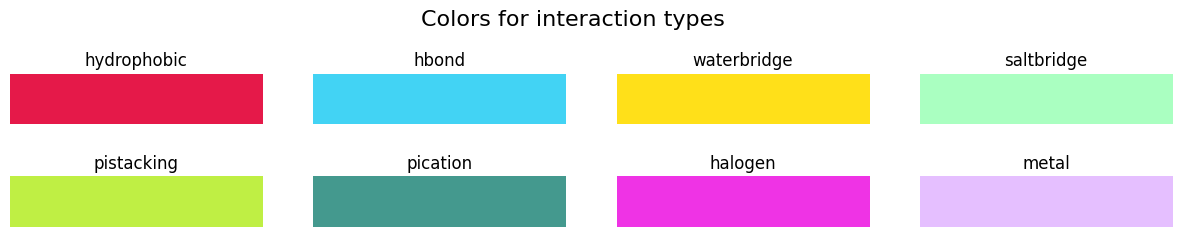

In [46]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15, 2))
plt.subplots_adjust(hspace=1)
fig.suptitle("Colors for interaction types", size=16, y=1.2)

for ax, (interaction, color) in zip(fig.axes, color_map.items()):
    ax.imshow(np.zeros((1, 5)), cmap=colors.ListedColormap(color_map[interaction]))
    ax.set_title(interaction, loc="center")
    ax.set_axis_off()
plt.show()

In [47]:
# viewer_3d = show_interactions_3d(pdb_id, interactions_by_site[selected_site])
# viewer_3d

interaction_data = create_df_from_binding_site(interactions_by_site[selected_site], interaction_type="halogen")

viewer = show_interactions_3d(
    pdb_id, 
    interactions_by_site[selected_site], 
    interaction_data=interaction_data,
    dash_length=0.3,
    dash_gap=0.2,
    
)
viewer


NGLWidget()

In [391]:
viewer.render_image(trim=True, factor=2, transparent=True);

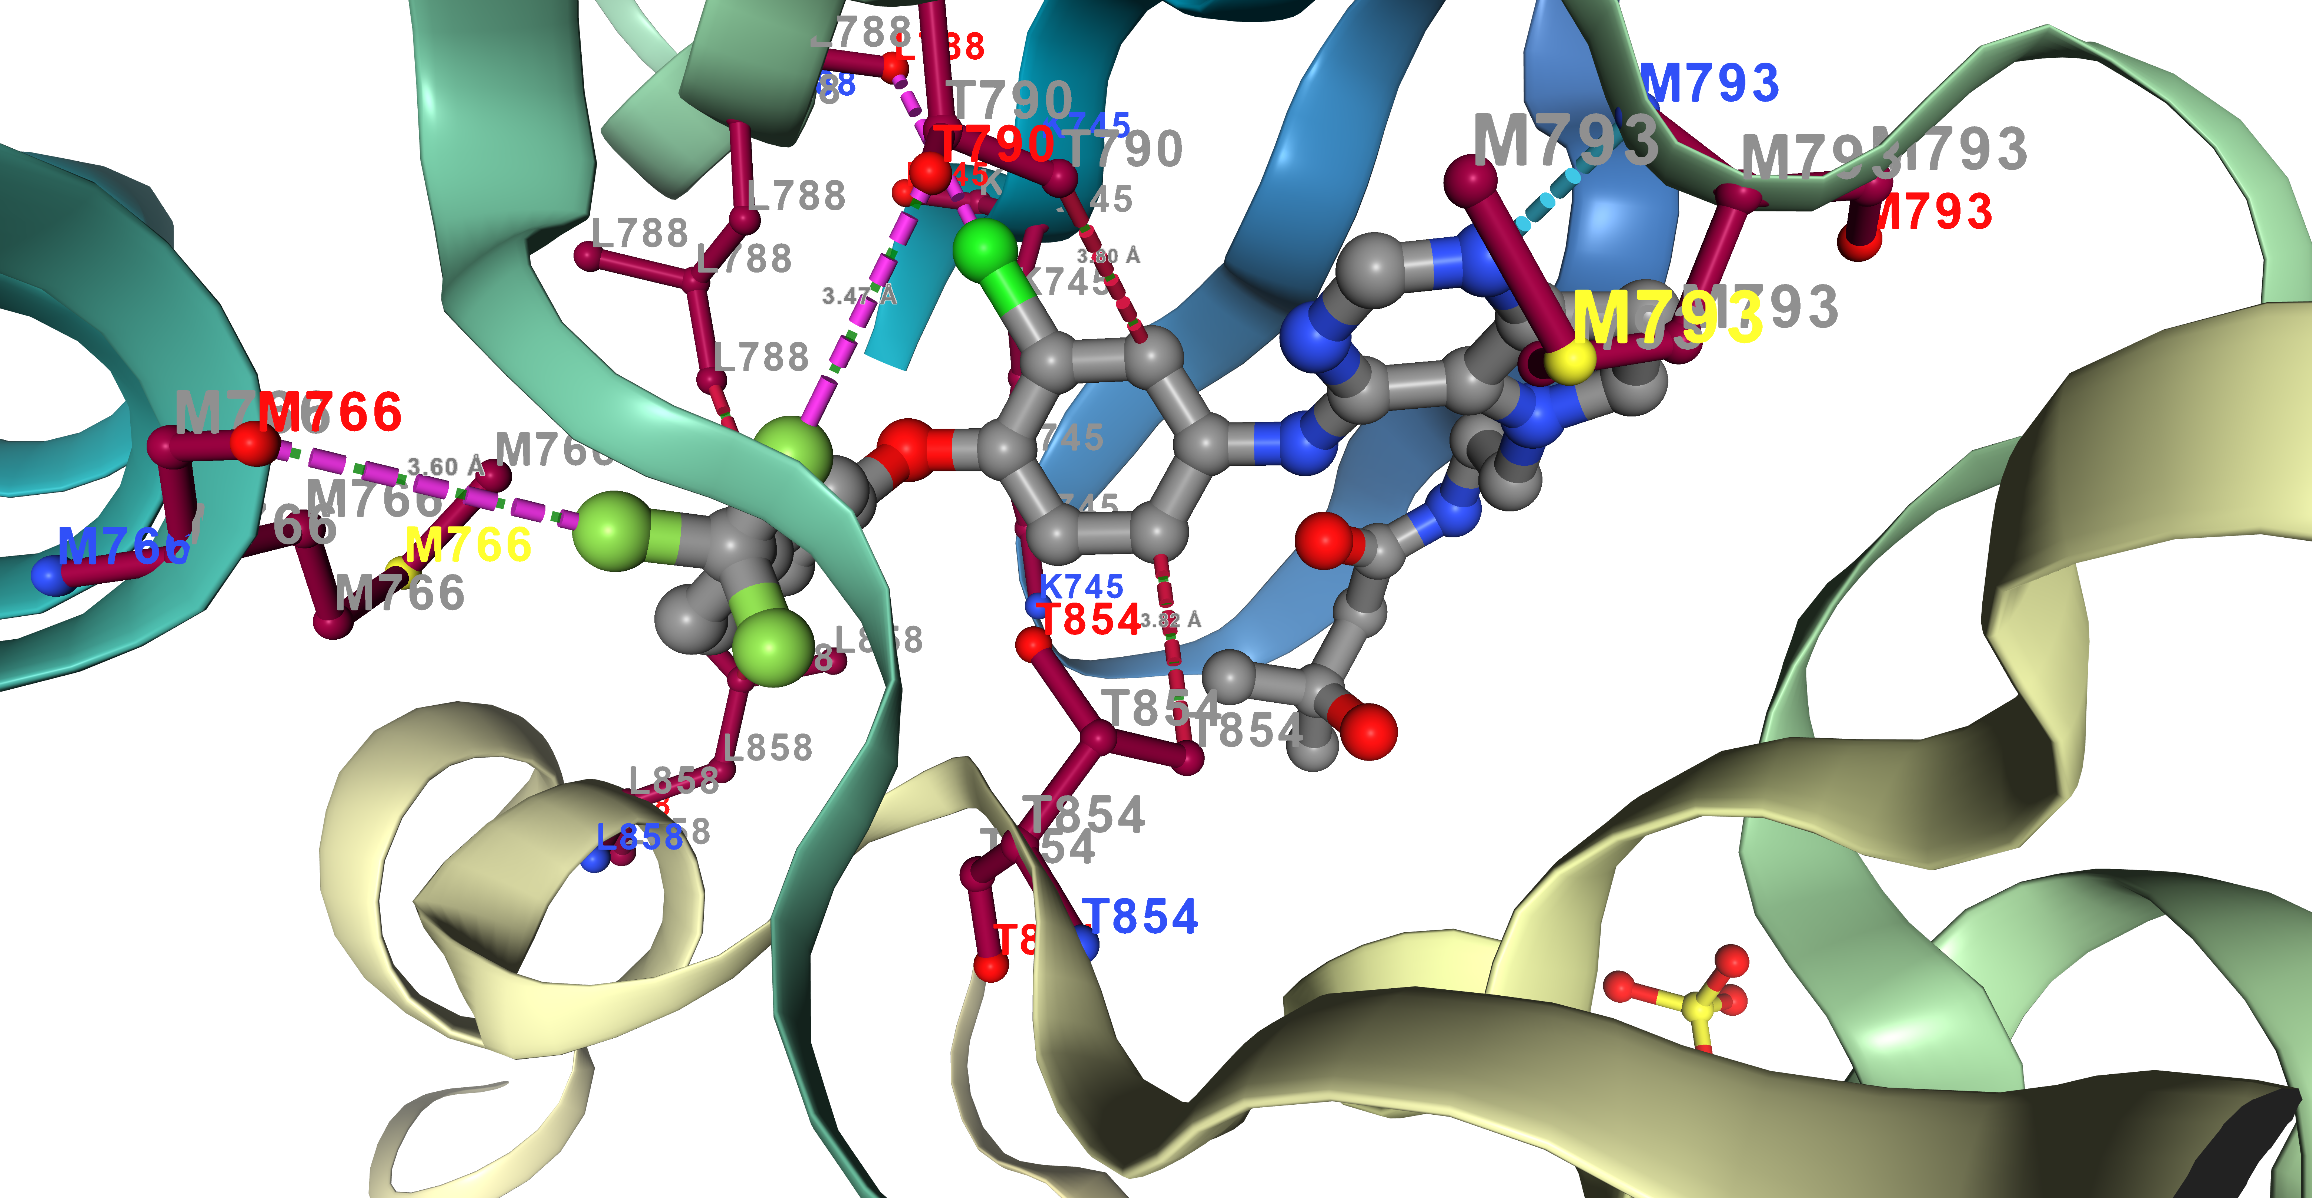

In [392]:
viewer._display_image()

# References

### Jupyter Dock 
https://github.com/AngelRuizMoreno/Jupyter_Dock/tree/main<br>
molecular docking in jupyter lab with visualization. very many options
### PLIP and TeachOpenCADD
https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T016_protein_ligand_interactions/talktorial.ipynb<br>
https://github.com/volkamerlab/teachopencadd/<br>
https://plip-tool.biotec.tu-dresden.de/plip-web/plip/result/d36f3394-1a01-433c-b770-5280cf63ec29<br>
protein ligand interaction profiler - can be implemented in jupyter notebook as here or you can use web server.
TeachOpenCADD - many tutorials on computer-aided drug design.
### NGLView
https://nglviewer.org/nglview/dev/api.html<br>
https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T017_advanced_nglview_usage/talktorial.ipynb<br>
must have if you need to do custom visualization. **interactive**. is used almost in every shown solution and reference
### LABODOCK
https://github.com/RyanZR/labodock<br>
molecular docking in google colaboratory with good visualization. bonus - you don't even see code if you don't want to, and all parameters can be changed in interactive way.
